In [1]:
import os
import logging
import cv2 as cv
import csv
import json
import pandas as pd
import gc

import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from torchvision import transforms

from utils.utils import draw_grad_cam, draw_roc, draw_confusion_matrix, std_mpl, ApplyCLAHE, show_transformed_images, mask2image, get_cam_metrics
from models.seg.UNet.unet_model import UNet, R2UNet
from utils.plot import plot_img_and_mask, std_mpl
from predict_utils import predict_mask, predict_to_mask
from utils.image2json import remap_mask_classes
import matplotlib.pyplot as plt
from utils.metrics import seg_metrics
std_mpl()

In [2]:
# setting
model_name = 'UNet'
load_path = '../train/train_save/checkpoints/HAM/UNet/2024-02-21/12/best.pth'
input_path = 'E:/Datas/work/HairEffect/RawData/HAM10000/HAM_Test/WithHair/Target/few/Image/mel'
masks_path = 'E:/Datas/work/HairEffect/RawData/HAM10000/HAM10000_MASKS'
output_path = f'./output/HAM/{model_name}/Test/Target/WithHair/few/mel'
predict_threshold = 0.5
size = (256, 256)
num_classes = 2 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

predict_path = f'{output_path}/predict'
cam_path = f'{output_path}/cam'
grayscale_cam_path = f'{output_path}/grayscale_cam'
indicators_path = f'{output_path}/indicators.csv'

os.makedirs(predict_path, exist_ok=True)
os.makedirs(cam_path, exist_ok=True)
os.makedirs(grayscale_cam_path, exist_ok=True)

indicators_header = ['image_name', 'inf1', 'inf2', 'inf3', 'inf', 'iou', 'dice']
with open(indicators_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(indicators_header)
    

In [3]:
if model_name.upper() == "UNET":
    model = UNet(n_channels=3, n_classes=num_classes)
    last_layer = model.up4
model.to(device=device)
state_dict = torch.load(load_path, map_location=device)
mask_values = state_dict.pop('mask_values', [0, 255])
model.load_state_dict(state_dict)
logging.info('Model loaded!')

INFO:root:Model loaded!


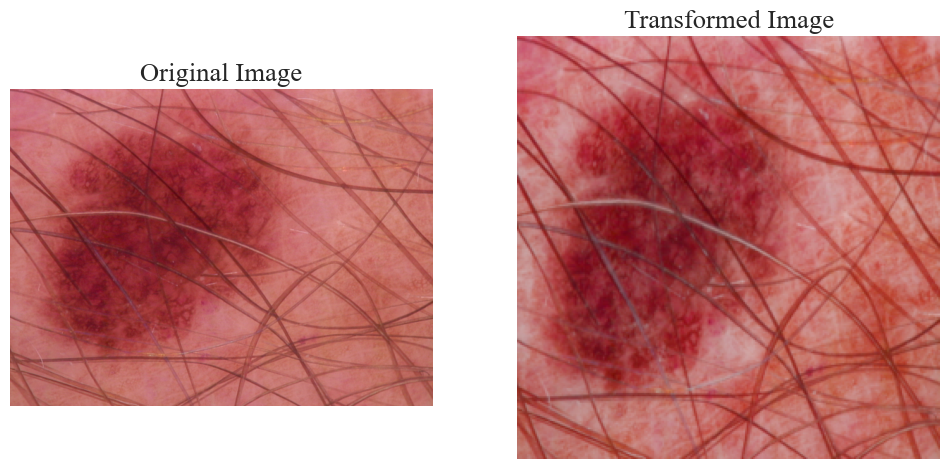

In [4]:
# image setting
images_path = os.listdir(input_path)

transform = transforms.Compose([
    transforms.Resize(size),
    ApplyCLAHE(channel='HSV', enhance=1),
    transforms.ToTensor(),
])

show_transformed_images(f'E:/Datas/work/HairEffect/RawData/HAM10000/HAM_Test/WithHair/many/Image/ISIC_0024320.jpg', transform)


In [5]:
# predict looping
all_true, all_proba, all_predict = [], [], []
count, max_samples = 0, 100
i = 0

for image_path in tqdm(images_path):
    full_image_path = f"{input_path}/{image_path}"
    image_name = image_path.split('.')[0]
    out_image_path = f'{predict_path}/{image_path}'
    
    image = Image.open(full_image_path)
    transformed_image = transforms.ToPILImage()(transform(image))
    
    predict, proba = predict_mask(
        model=model,
        image=transformed_image,
        size=size,
        threshold=predict_threshold,
        device=device
    )
    result_img, result = predict_to_mask(predict=predict, mask_values=mask_values)
    result_normal = result / 255.
    result_img.save(out_image_path)
    
    if masks_path is not None:
        plots_path = f'{output_path}/plots'
        os.makedirs(plots_path, exist_ok=True)
        
        full_mask_path = f'{masks_path}/{image_path}'
        true_mask = np.copy(np.asarray(Image.open(full_mask_path).convert('L'))) # turn to grayscale 
        true_mask_resize = cv.resize(true_mask, size)
        true_mask_remap = remap_mask_classes(true_mask_resize, mask_values)
        true_mask_normal = true_mask_remap / 255.
        
        plot_img_and_mask(image=transformed_image, predict_mask=result, true_mask=true_mask_remap, colors=[[255, 255, 0]], save_path=f'{plots_path}/{image_path}')
        
        inf1, inf2, inf3, inf = get_cam_metrics(model=model, target_layers=[last_layer], cuda=True, pil_image=transformed_image, target_category=1, true_mask=true_mask_normal, save_path=f'{grayscale_cam_path}/{image_path}')
        
        iou, dice = seg_metrics(result_normal, true_mask_normal)
        
        
        
        indicators_row = [image_name, inf1, inf2, inf3, inf, iou, dice]
        with open(indicators_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(indicators_row)
        
        if count < max_samples:
            all_true.extend(true_mask_normal.flatten())
            all_proba.extend(proba[1].flatten())
            all_predict.extend(predict[1].flatten())
            count += 1

    draw_grad_cam(model=model, target_layers=[last_layer], cuda=True, pil_image=transformed_image, target_category=1, save_path=f'{cam_path}/{image_path}')
    i += 1
    if i > 2000:
        break

  0%|          | 0/29 [00:00<?, ?it/s]INFO:root:Save plot
INFO:root:Save Cam
  3%|▎         | 1/29 [00:02<01:19,  2.83s/it]INFO:root:Save plot
INFO:root:Save Cam
  7%|▋         | 2/29 [00:03<00:45,  1.70s/it]INFO:root:Save plot
INFO:root:Save Cam
 10%|█         | 3/29 [00:04<00:35,  1.37s/it]INFO:root:Save plot
INFO:root:Save Cam
 14%|█▍        | 4/29 [00:05<00:29,  1.17s/it]INFO:root:Save plot
INFO:root:Save Cam
 17%|█▋        | 5/29 [00:06<00:25,  1.06s/it]INFO:root:Save plot
INFO:root:Save Cam
 21%|██        | 6/29 [00:07<00:22,  1.00it/s]INFO:root:Save plot
INFO:root:Save Cam
 24%|██▍       | 7/29 [00:08<00:20,  1.05it/s]INFO:root:Save plot
INFO:root:Save Cam
 28%|██▊       | 8/29 [00:09<00:19,  1.08it/s]INFO:root:Save plot
INFO:root:Save Cam
 31%|███       | 9/29 [00:10<00:18,  1.06it/s]INFO:root:Save plot
INFO:root:Save Cam
 34%|███▍      | 10/29 [00:10<00:17,  1.09it/s]INFO:root:Save plot
INFO:root:Save Cam
 38%|███▊      | 11/29 [00:11<00:16,  1.12it/s]INFO:root:Save plot
INFO:

In [6]:
fpr, tpr = draw_roc(np.array(all_true), np.array(all_proba), title='ROC', class_labels=['few']) 
plt.close()

roc_dice = {'fpr': fpr.tolist(), 'tpr': tpr.tolist()}

with open(f'{output_path}/roc_data.txt', 'w') as file:
    file.write(json.dumps(roc_dice))


In [7]:
draw_confusion_matrix(all_true, all_predict, display_labels=['disease', 'background'])
plt.savefig(f'{output_path}/CM.jpg')
plt.close()

del all_true, all_proba
gc.collect()

481747

# stop

In [8]:
# mask to image
mask2image_save_path = f"{output_path}/mask2image"
os.makedirs(mask2image_save_path, exist_ok=True)
masks_path = os.listdir(predict_path) 

for mask_path in tqdm(masks_path):
    full_mask_path = f"{predict_path}/{mask_path}"
    full_image_path = f"{input_path}/{mask_path}"
    full_mask2image_save_path = f"{mask2image_save_path}/{mask_path}"
    mask2image(full_mask_path, full_image_path, full_mask2image_save_path, size)

100%|██████████| 61/61 [00:00<00:00, 90.81it/s]


In [ ]:
# show mask and image
import cv2 as cv
import matplotlib.pyplot as plt
import gc

mask2image_save_path = f"{output_path}/mask2image"
os.makedirs(mask2image_save_path, exist_ok=True)
masks_path = os.listdir(predict_path) 
check_path = f"{output_path}/check"
os.makedirs(check_path, exist_ok=True)

for mask_path in tqdm(masks_path):
    full_mask_path = f"{mask2image_save_path}/{mask_path}"
    full_image_path = f"{input_path}/{mask_path}"
    
    image = cv.imread(full_image_path)
    mask = cv.imread(full_mask_path)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    mask_rgb = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
    
    # Display the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')  # Hide axis

    # Display the processed image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(mask_rgb)
    plt.title('Processed Image')
    plt.axis('off')  # Hide axis
    plt.savefig(f'{check_path}/{mask_path}')
    plt.clf()
    plt.close()
    del image, mask, image_rgb, mask_rgb
    gc.collect()

# Box plot

In [9]:
# Draw box plots for indicators
import pandas as pd
import seaborn as sns

targets = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

for target in tqdm(targets):
    # no_hair_path = f'./output/HAM/UNet/Train/NoHair/indicators.csv'
    # few_hair_path = f'./output/HAM/UNet/Train/WithHair/few/indicators.csv'
    # many_hair_path = f'./output/HAM/UNet/Train/WithHair/many/indicators.csv'
    # save_path = f'./output/HAM/UNet/Train/all-mBox.jpg'

    no_hair_path = f'./output/HAM/UNet/Train/Target/NoHair/{target}/indicators.csv'
    few_hair_path = f'./output/HAM/UNet/Train/Target/WithHair/few/{target}/indicators.csv'
    many_hair_path = f'./output/HAM/UNet/Train/Target/WithHair/many/{target}/indicators.csv'
    save_path = f'./output/HAM/UNet/Train/{target}-mBox.jpg'

    df1 = pd.read_csv(no_hair_path)
    df2 = pd.read_csv(few_hair_path)
    df3 = pd.read_csv(many_hair_path)

    # normalize distance
    for df in [df1, df2, df3]:
        
        min_inf3 = df['inf3'].min()
        max_inf3 = df['inf3'].max()
        df['inf3'] = (df['inf3'] - min_inf3) / (max_inf3 - min_inf3)
        
        df['inf'] = (2 * df['inf2'] + df['inf3']) / 3
        min_inf = df['inf'].min()
        max_inf = df['inf'].max()
        df['inf'] = (df['inf'] - min_inf) / (max_inf - min_inf)
        
    df1['Condition'] = 'no'
    df2['Condition'] = 'few'
    df3['Condition'] = 'many'
    
    df_combined = pd.concat([df1, df2, df3])
    df_melted = df_combined.melt(id_vars='Condition', value_vars=['inf2', 'inf3', 'inf'], var_name='Metric', value_name='Value')
    
    fig, ax = plt.subplots(dpi=2000, figsize=(14, 8))
    sns.boxplot(x='Metric', y='Value', hue='Condition', data=df_melted, palette=['#ff7f0e', '#da5bac', '#1f77b4'],showfliers=False, ax=ax)
    sns.stripplot(x='Metric', y='Value', hue='Condition', data=df_melted, palette=['#ff7f0e', '#da5bac', '#1f77b4'], size=2, jitter=True, dodge=True, linewidth=0.5, alpha=0.5, ax=ax)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    plt.ylabel('Metric Value')
    legend = ax.legend(loc='upper right',bbox_to_anchor=(1.1, 1), frameon=False)
    plt.savefig(save_path)
    plt.clf()
    plt.close()

  0%|          | 0/7 [00:00<?, ?it/s]E:\CondaEvens\PyTorch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\CondaEvens\PyTorch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\CondaEvens\PyTorch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\CondaEvens\PyTorch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

# ALL ROC

In [5]:
from sklearn.metrics import auc

save_path = './output/HAM/UNet/Test/All/All_roc.jpg'
targets = ['all', 'akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, target in tqdm(enumerate(targets)):
    roc_value_path = f'./output/HAM/UNet/Test/All/{target}/roc_data.txt'
    with open(roc_value_path, 'r') as f:
        roc_dict = json.load(f)
    fpr[i], tpr[i] = roc_dict['fpr'], roc_dict['tpr']
    roc_auc[i] = auc(fpr[i], tpr[i])

title = 'none'

fig, ax = plt.subplots(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink']
for i, color in zip(range(len(targets)), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'ROC curve of {targets[i]} (area = {np.around(roc_auc[i], 4)})')
    
    ax.plot([0, 1], [0, 1], color='#d8d8d8', lw=1.5, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.spines['top'].set_color('none')  # 将顶部边框线颜色设置为透明
    ax.spines['right'].set_color('none')  # 将右侧边框线颜色设置为透明
    ax.spines['left'].set_color('black')  
    ax.spines['bottom'].set_color('black')  
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    plt.legend(loc="lower right", frameon=False)

plt.savefig(save_path)
plt.clf()
plt.close()

8it [00:08,  1.12s/it]
